Analysis employs various ML regression techniques to identify marketing channels most associated with product sales.

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

In [2]:
# Import the dataset - columns - TV, radio, newspaper, Google, Facebook, Linkedin, and sales
dataset = pd.read_csv('Marketing.csv')

## Data analysis

In [3]:
# Examine first five rows of data
dataset.head()

,TV,radio,newspaper,Google,Facebook,Linkedin,sales
0,230.1,37.8,69.2,267.9,160.9,107.0,22.1
1,44.5,39.3,45.1,83.8,-0.6,84.4,10.4
2,17.2,45.9,69.3,63.1,-52.1,115.2,9.3
3,151.5,41.3,58.5,192.8,93.0,99.8,18.5
4,180.8,10.8,58.4,191.6,122.4,69.2,12.9


In [4]:
# overview of data
dataset.describe()

,TV,radio,newspaper,Google,Facebook,Linkedin,sales
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,170.306500,116.488500,53.818000,14.022500
std,85.854236,14.846809,21.778621,87.926689,87.369442,30.392927,5.217457
min,0.700000,0.000000,0.300000,10.700000,-72.500000,3.100000,1.600000
25%,74.375000,9.975000,12.750000,90.625000,42.575000,30.875000,10.375000
50%,149.750000,22.900000,25.750000,175.550000,124.450000,46.400000,12.900000
75%,218.825000,36.525000,45.100000,243.300000,183.900000,73.950000,17.400000
max,296.400000,49.600000,114.000000,332.700000,291.800000,150.600000,27.000000


In [5]:
# check for null data fields
dataset.isnull().sum()

TV           0
radio        0
newspaper    0
Google       0
Facebook     0
Linkedin     0
sales        0
dtype: int64

In [6]:
dataset.corr(method='pearson')

,TV,radio,newspaper,Google,Facebook,Linkedin,sales
TV,1.000000,0.054809,0.056648,0.985684,0.968537,0.067366,0.782224
radio,0.054809,1.000000,0.354104,0.222371,-0.034409,0.742235,0.576223
newspaper,0.056648,0.354104,1.000000,0.115105,-0.193605,0.889547,0.228299
Google,0.985684,0.222371,0.115105,1.000000,0.939898,0.191108,0.861085
Facebook,0.968537,-0.034409,-0.193605,0.939898,1.000000,-0.155540,0.711750
Linkedin,0.067366,0.742235,0.889547,0.191108,-0.155540,1.000000,0.445074
sales,0.782224,0.576223,0.228299,0.861085,0.711750,0.445074,1.000000


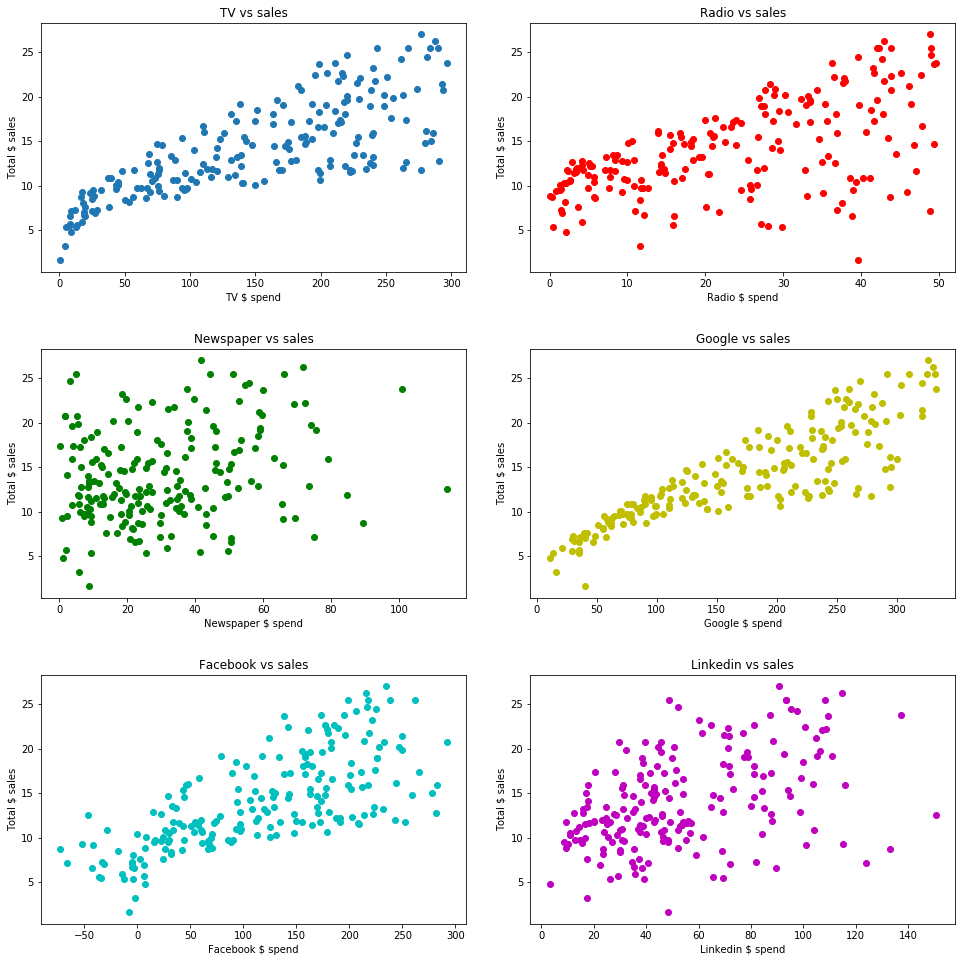

In [7]:
# visualize relationship among variables/target by creating scatter plots for each variable

y_label = 'Total $ sales'

fig, axs = plt.subplots(3, 2, figsize=(14,14))
axs[0, 0].scatter(dataset['TV'], dataset['sales'])
axs[0, 0].set_title('TV vs sales')
axs[0, 0].set(xlabel='TV $ spend', ylabel= y_label)

axs[0, 1].scatter(dataset['radio'], dataset['sales'],  color='r')
axs[0, 1].set_title('Radio vs sales')
axs[0, 1].set(xlabel='Radio $ spend', ylabel= y_label)

axs[1, 0].scatter(dataset['newspaper'], dataset['sales'],  color='g')
axs[1, 0].set_title('Newspaper vs sales')
axs[1, 0].set(xlabel='Newspaper $ spend', ylabel= y_label)

axs[1, 1].scatter(dataset['Google'], dataset['sales'],  color='y')
axs[1, 1].set_title('Google vs sales')
axs[1, 1].set(xlabel='Google $ spend', ylabel= y_label)

axs[2, 0].scatter(dataset['Facebook'], dataset['sales'],  color='c')
axs[2, 0].set_title('Facebook vs sales')
axs[2, 0].set(xlabel='Facebook $ spend', ylabel= y_label)

axs[2, 1].scatter(dataset['Linkedin'], dataset['sales'],  color='m')
axs[2, 1].set_title('Linkedin vs sales')
axs[2, 1].set(xlabel='Linkedin $ spend', ylabel= y_label)

fig.tight_layout(pad=3.0)

Linkedin and newspaper ad spending are much less related to sales when compared with other variables. This should be taken into consideration when modeling.

Also note that Facebook data contains negative values that should be considered.

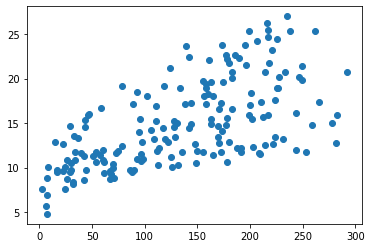

In [8]:
# Create a dataframe with negative values removed
df_FBx = dataset.copy()
negs = df_FBx[df_FBx['Facebook'] < 0].index
df_FBx.drop(negs, inplace=True)

# visualize new dataset
plt.scatter(df_FBx['Facebook'], df_FBx['sales'])

In [9]:
df_FBx.corr(method='pearson')

,TV,radio,newspaper,Google,Facebook,Linkedin,sales
TV,1.000000,0.127984,0.220714,0.983063,0.963928,0.222675,0.713578
radio,0.127984,1.000000,0.315535,0.307576,0.044969,0.738190,0.734987
newspaper,0.220714,0.315535,1.000000,0.270062,-0.046847,0.873055,0.374201
Google,0.983063,0.307576,0.270062,1.000000,0.933115,0.350045,0.820432
Facebook,0.963928,0.044969,-0.046847,0.933115,1.000000,-0.010196,0.628700
Linkedin,0.222675,0.738190,0.873055,0.350045,-0.010196,1.000000,0.643713
sales,0.713578,0.734987,0.374201,0.820432,0.628700,0.643713,1.000000


In [10]:
# split data into a training and test set:
X = dataset[['TV', 'radio', 'newspaper', 'Google', 'Facebook', 'Linkedin']]
y = dataset[['sales']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [11]:
# do same for data with negative FB values removed
X2 = df_FBx[['TV', 'radio', 'newspaper', 'Google', 'Facebook', 'Linkedin']]
y2 = df_FBx[['sales']]

# Split X2 and y2 into test and training
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size =0.2, random_state=1)

## Linear Regression

In [12]:
lr = LinearRegression().fit(X_train, y_train)

print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)
print("LR training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("LR test set score: {:.2f}".format(lr.score(X_test, y_test)))

lr.coef_: [[-0.02056799  0.07691485 -0.03163222  0.05634686  0.01106423  0.04528263]]
lr.intercept_: [2.90794702]
LR training set score: 0.90
LR test set score: 0.89


In [13]:
# print coefficients with feature names
for idx, col_name in enumerate(X_train.columns):
    print("The LR coefficient for {} is {}".format(col_name, lr.coef_[0][idx]))
    
print("The LR intercept for this model is {}".format(lr.intercept_))

The LR coefficient for TV is -0.020567987840226568
The LR coefficient for radio is 0.0769148495866932
The LR coefficient for newspaper is -0.03163221711097688
The LR coefficient for Google is 0.05634686174646662
The LR coefficient for Facebook is 0.011064229270750375
The LR coefficient for Linkedin is 0.04528263247571623
The LR intercept for this model is [2.90794702]


In [14]:
# Calculate how closely this model matches reality
rSquared = lr.score(X_test, y_test)

# multiply decimal by 100 to get the percent!
print("In Linear Regression model, %s percent of the variability in Y can be explained using X." % (100*rSquared))

In Linear Regression model, 89.27605914615383 percent of the variability in Y can be explained using X.


In [15]:
# make predictions using the test set
y_predict = lr.predict(X_test)
lr_model_mse = mean_squared_error(y_predict, y_test)

mseRoot = math.sqrt(lr_model_mse)
print("MSE %s." % mseRoot)

MSE 1.4113417558581591.


In [16]:
# test results with negative values removed
lr2 = LinearRegression().fit(X_train2, y_train2)

print("lr.coef_:", lr2.coef_)
print("lr.intercept_:", lr2.intercept_)
print("LR training set score: {:.2f}".format(lr2.score(X_train2, y_train2)))
print("LR test set score: {:.2f}".format(lr2.score(X_test2, y_test2)))

lr.coef_: [[-0.02799843  0.08845916 -0.03558051  0.06046072  0.00758208  0.05287865]]
lr.intercept_: [3.5507388]
LR training set score: 0.94
LR test set score: 0.91


In [17]:
#Calculate how closely this non-neg model matches reality
rSquared2 = lr2.score(X_test2, y_test2)

# multiply decimal by 100 to get the percent!
print("In Linear Regression model, %s percent of the variability in Y can be explained using X." % (100*rSquared2))

In Linear Regression model, 90.5945198246058 percent of the variability in Y can be explained using X.


In [18]:
# make predictions using the non-neg test set
y_predict2 = lr2.predict(X_test2)
lr_model_mse2 = mean_squared_error(y_predict2, y_test2)

mseRoot2 = math.sqrt(lr_model_mse2)
print("MSE %s." % mseRoot2)

MSE 1.4253933778925854.


## Ridge Regression

In [19]:
ridge = Ridge(alpha=.1).fit(X_train, y_train) # values of alpha ranging from .01-10 tested and had no impact on results

print("ridge.coef_:", ridge.coef_)
print("ridge.intercept_:", ridge.intercept_)
print("Ridge training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Ridge test set score: {:.2f}".format(ridge.score(X_test, y_test)))

ridge.coef_: [[-0.02056788  0.07691468 -0.03163208  0.05634679  0.0110642   0.04528259]]
ridge.intercept_: [2.90794932]
Ridge training set score: 0.90
Ridge test set score: 0.89


In [20]:
ridge.alpha

0.1

In [21]:
# print coefficients with feature names
for idx, col_name in enumerate(X_train.columns):
    print("The Ridge coefficient for {} is {}".format(col_name, ridge.coef_[0][idx]))
    
print("The Ridge intercept for our model is {}".format(ridge.intercept_))

The Ridge coefficient for TV is -0.02056788350643054
The Ridge coefficient for radio is 0.07691467561818095
The Ridge coefficient for newspaper is -0.03163208172168915
The Ridge coefficient for Google is 0.056346791771465225
The Ridge coefficient for Facebook is 0.011064198075577732
The Ridge coefficient for Linkedin is 0.045282593835707555
The Ridge intercept for our model is [2.90794932]


In [22]:
rSquared = ridge.score(X_test, y_test) 

# multiply decimal by 100 to get the percent
print("In Ridge Linear Regression model, %s percent of the variability in Y can be explained using X." % (100*rSquared))


In Ridge Linear Regression model, 89.27602719319276 percent of the variability in Y can be explained using X.


In [23]:
# calculate MSE
y_predict = ridge.predict(X_test)
ridge_model_mse = mean_squared_error(y_predict, y_test)
mseRoot = math.sqrt(ridge_model_mse)

print("Ridge MSE %s " % mseRoot)

Ridge MSE 1.4113438584674136 


In [24]:
# test ridge with negative values removed from data
ridge2 = Ridge().fit(X_train2, y_train2)

print("ridge.coef_:", ridge2.coef_)
print("ridge.intercept_:", ridge2.intercept_)
print("Ridge training set score: {:.2f}".format(ridge2.score(X_train, y_train)))
print("Ridge test set score: {:.2f}".format(ridge2.score(X_test, y_test)))

ridge.coef_: [[-0.02799716  0.08845698 -0.03557892  0.06045982  0.00758176  0.05287806]]
ridge.intercept_: [3.55077581]
Ridge training set score: 0.87
Ridge test set score: 0.91


In [25]:
rSquared2 = ridge2.score(X_test2, y_test2) 

# multiply decimal by 100 to get the percent
print("In Ridge Linear Regression model, %s percent of the variability in Y can be explained using X." % (100*rSquared2))


In Ridge Linear Regression model, 90.59424238286798 percent of the variability in Y can be explained using X.


In [26]:
# calculate MSE with negative values removed
y_predict2 = ridge2.predict(X_test2)
ridge_model_mse2 = mean_squared_error(y_predict2, y_test2)
mseRoot2 = math.sqrt(ridge_model_mse2)

print("Ridge MSE %s " % mseRoot2)

Ridge MSE 1.425414400779889 


## Lasso Regression

In [27]:
lasso = Lasso(alpha=0.1, max_iter=100000).fit(X_train, y_train)

print("Lasso.coef_:", lasso.coef_)
print("Lasso.intercept_:", lasso.intercept_)
print("Lasso training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Lasso test set score: {:.2f}".format(lasso.score(X_test, y_test)))
    
print("Number of features used:", np.sum(lasso.coef_ != 0))

Lasso.coef_: [0.02361249 0.1520925  0.         0.02323422 0.         0.00272295]
Lasso.intercept_: [2.91486414]
Lasso training set score: 0.90
Lasso test set score: 0.89
Number of features used: 4


In [28]:
# print coefficients with feature names
for idx, col_name in enumerate(X_train.columns):
    print("The Lasso coefficient for {} is {}".format(col_name, lasso.coef_[idx]))
    
print("The Lasso intercept for our model is {}".format(lasso.intercept_))


The Lasso coefficient for TV is 0.023612493803277568
The Lasso coefficient for radio is 0.1520925007816029
The Lasso coefficient for newspaper is 0.0
The Lasso coefficient for Google is 0.02323421754580889
The Lasso coefficient for Facebook is 0.0
The Lasso coefficient for Linkedin is 0.0027229482377865172
The Lasso intercept for our model is [2.91486414]


In [29]:
rSquared = lasso.score(X_test, y_test) 

#multiply decimal by 100 to get the percent
print("In Lasso Linear Regression model, %s percent of the variability in Y can be explained using X." % (100*rSquared))

In Lasso Linear Regression model, 89.22389701834196 percent of the variability in Y can be explained using X.


In [30]:
#calculate MSE
y_predict = lasso.predict(X_test)
lasso_model_mse = mean_squared_error(y_predict, y_test)
mseRoot = math.sqrt(lasso_model_mse)

print("Lasso MSE %s " % mseRoot)

Lasso MSE 1.4147700330840671 


In [31]:
# model non-negative dataset using Lasso
lasso2 = Lasso(alpha=0.1, max_iter=100000).fit(X_train2, y_train2)

print("Lasso.coef_:", lasso2.coef_)
print("Lasso.intercept_:", lasso2.intercept_)
print("Lasso training set score: {:.2f}".format(lasso2.score(X_train2, y_train2)))
print("Lasso test set score: {:.2f}".format(lasso2.score(X_test2, y_test2)))
    
print("Number of features used:", np.sum(lasso2.coef_ != 0))

Lasso.coef_: [0.01332379 0.16477266 0.         0.02672989 0.         0.00980284]
Lasso.intercept_: [3.55819343]
Lasso training set score: 0.94
Lasso test set score: 0.91
Number of features used: 4


In [32]:
# check r-squared for non-negative lasso model
rSquared2 = lasso2.score(X_test2, y_test2) 

#multiply decimal by 100 to get the percent
print("In Lasso Linear Regression model, %s percent of the variability in Y can be explained using X." % (100*rSquared2))

In Lasso Linear Regression model, 90.5581614879309 percent of the variability in Y can be explained using X.


In [33]:
#calculate RMSE for non-negative lasso model 
y_predict2 = lasso2.predict(X_test2)
lasso_model_mse2 = mean_squared_error(y_predict2, y_test2)
mseRoot2 = math.sqrt(lasso_model_mse2)

print("Lasso MSE %s " % mseRoot2)

Lasso MSE 1.4281457596749378 
